In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
from torch import nn
import albumentations as A
# import torchsummary
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

torch.cuda.empty_cache()

BS=16
LR=0.00005
epochs=20
IS=256
D='cuda' if torch.cuda.is_available() else 'cpu'

num_classes = 7
classes=['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
c2l={k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c={v:k for k,v in c2l.items()}

dir_path='c:/users/ashkanreisi/desktop/cs 791- ids/Data'
train_dir_path='c:/users/ashkanreisi/desktop/cs 791- ids/Data/train'
train_img_paths = sorted(os.listdir("c:/users/ashkanreisi/desktop/cs 791- ids/Data/train/images"))
train_target_paths = sorted(os.listdir('c:/users/ashkanreisi/desktop/cs 791- ids/Data/train/labels'))

val_dir_path='c:/users/ashkanreisi/desktop/cs 791- ids/Data/valid'
val_img_paths = sorted(os.listdir('c:/users/ashkanreisi/desktop/cs 791- ids/Data/valid/images'))
val_target_paths = sorted(os.listdir('c:/users/ashkanreisi/desktop/cs 791- ids/Data/valid/labels'))

C:\Users\ashkanreisi\AppData\Local\Temp\ipykernel_25108\3625738177.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
c:\Users\ashkanreisi\AppData\Local\anaconda3\envs\mamo\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56

In [168]:
def unconvert(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax

In [68]:
len(target)

10

4
8
12
16
20


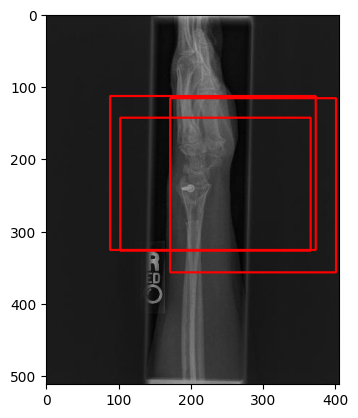

In [275]:
idx=random.randint(0,3000)
# idx=0
ip=os.path.join(train_dir_path,'images',train_img_paths[6])
tp=os.path.join(train_dir_path,'labels',train_target_paths[6])

image=cv2.imread(ip)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#image=cv2.resize(image,(320,320))

file=open(tp,'r')
target=list(map(float,file.read().split()))[1:]

a=0
while a<len(target):
    bbox=target[a:a+4]
    if len(bbox)==4:
        x,y,w,h=bbox[0], bbox[1], bbox[2], bbox[3]
        xmin,ymin,xmax,ymax=unconvert(image.shape[0],image.shape[1],x,y,w,h)
        sp,ep=(xmin,ymin),(xmax,ymax)
        image=cv2.rectangle(image,sp,ep,(255,0,0),2)
    a+=4
    print(a)

plt.imshow(image)
plt.show()

In [3]:
#Saving the number of annotations's coordiantes for each image
Title=[]
TitleLen=[]
for i in range (3631):
    tp=os.path.join(train_dir_path,'labels',train_target_paths[i])
    Title.append(tp)
    file=open(tp,'r')
    target=list(map(float,file.read().split()))[1:]
    TitleLen.append(len(target))

In [18]:
from collections import Counter
counted = Counter(TitleLen)

numOfCords=[]
frequancy=[]
# Print the results
''''''
for num, freq in counted.items():
    #print(f"Annotations with {num} coordiantes is repeated {freq} times.")
    numOfCords.append(num)
    frequancy.append(freq)

i=0
while i<len(numOfCords):
    for j in range(3631):
        if TitleLen[j]==numOfCords[i]:
            #print(numOfCords[i],Title[j])
            print("Annotations with",numOfCords[i], "coordiantes is repeated", frequancy[i],"which first happened in: ",Title[j])
            break
    i=i+1




Annotations with 8 coordiantes is repeated 435 which first happened in:  c:/users/ashkanreisi/desktop/cs 791- ids/Data/train\labels\distal-humeral-fractures-2-_JPEG.rf.39ba3f53047ecb4064613850a1c76fc1.txt
Annotations with 10 coordiantes is repeated 964 which first happened in:  c:/users/ashkanreisi/desktop/cs 791- ids/Data/train\labels\distal-humeral-fractures-2-_JPEG.rf.525ce876785d0fd798ec3af1593e5bc1.txt
Annotations with 12 coordiantes is repeated 117 which first happened in:  c:/users/ashkanreisi/desktop/cs 791- ids/Data/train\labels\elbow-dislocation-with-coronoid-process-fracture_jpg.rf.234153519323ba2b9aa2e603b0a43771.txt
Annotations with 0 coordiantes is repeated 1827 which first happened in:  c:/users/ashkanreisi/desktop/cs 791- ids/Data/train\labels\image1_0_png.rf.208b9fc171409973fd0f9af79cdcfead.txt
Annotations with 21 coordiantes is repeated 162 which first happened in:  c:/users/ashkanreisi/desktop/cs 791- ids/Data/train\labels\image1_1002_png.rf.1feafce607366113c97124dc2

In [199]:
target

[6.0,
 0.450923327262856,
 0.5429814947602236,
 0.5550259302921843,
 0.524430479130555,
 0.5581604824156166,
 0.5832826623523972,
 0.4474074499689369,
 0.5932294817181911,
 6.0,
 0.4443919925122576,
 0.44147026544115653,
 0.579057283998574,
 0.45728929031060694,
 0.5801021081347276,
 0.513654737070833,
 0.4515868262285229,
 0.5260882928982431]

In [200]:
#Drawing polylines

idx=random.randint(0,3000)
# idx=0
ip=os.path.join(train_dir_path,'images',train_img_paths[17])
tp=os.path.join(train_dir_path,'labels',train_target_paths[17])

image=cv2.imread(ip)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
Width=image.shape[0]
Height=image.shape[1]
image=cv2.resize(image,(320,320))

def Polylines_Method1(tp): # Puts all coordinates as pairs to be drawn as one big poyline by cv2.polylines
    target=[]   
    with open(tp,'r') as file:
        for line in file:
            temp_target=list(map(float,line.split()))
            target=target+temp_target
    return target

def Polylines_Method2(tp):
    target=[]
    with open(tp,'r') as file:
        for line in file:
            target.append(line)
    return target

target=Polylines_Method1(tp)
#target=Polylines_Method2(tp)
    


Cordinations_Fracture=[0]*len(target[0][1:])# To store the cordinates of the fractured part of the image
for i in range(len(target)):
    Cordinations_Fracture[i]=int(target[i]*320)
       
    
vertices_np=np.array(Cordinations_Fracture)
vertices_np = vertices_np.reshape(-1,1,2) 
image_with_rectangle=cv2.polylines(image, [vertices_np], isClosed=True, color=(0, 255, 0), thickness=2)

plt.imshow(image)
plt.show()

ValueError: invalid literal for int() with base 10: '6 0.450923327262856 0.5429814947602236 0.5550259302921843 0.524430479130555 0.5581604824156166 0.5832826623523972 0.4474074499689369 0.5932294817181911\n6 0.450923327262856 0.5429814947602236 0.55502

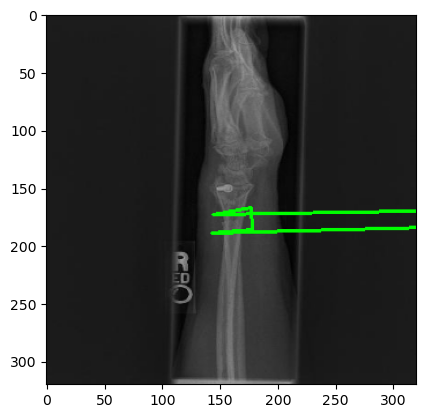

In [109]:
def unconvert(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax


idx=random.randint(0,3000)
# idx=0
ip=os.path.join(train_dir_path,'images',train_img_paths[17])
tp=os.path.join(train_dir_path,'labels',train_target_paths[17])

image=cv2.imread(ip)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
Width=image.shape[0]
Height=image.shape[1]
image=cv2.resize(image,(320,320))

file=open(tp,'r')
target=list(map(float,file.read().split()))[1:]


    
    
x0=int(target[0]*320)#*320/Width)
y0=int(target[1]*320)#*320/Height)
x1=int(target[2]*320)#*320/Width)
y1=int(target[3]*320)#*320/Height)
x2=int(target[4]*320)#*320/Width)
y2=int(target[5]*320)#*320/Height)
x3=int(target[6]*320)#320/Width)
y3=int(target[7]*320)#*320/Height)
x4=int(target[8]*320)
y4=int(target[9]*320)
#x5=int(target[10])*320
#y5=int(target[11])*320
#A=[xmin0,ymin0,xmax0,ymax0] 
       
def coordiantes(xCen,yCen,h,w):
    xA=int(xCen-h/2)
    yA=int(yCen-w/2)
    xB=int(xCen+h/2)
    yB=int(yCen+w/2)
    return(xA,yA,xB,yB)        
#image=cv2.rectangle(image,(xmin0,ymin0),(xmin0+xmax0,ymin0+ymax0),(255,0,0),2)

    
vertices_np=np.array([[x0,y0],[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
vertices_np = vertices_np.reshape(-1,1,2) 
image_with_rectangle=cv2.polylines(image, [vertices_np], isClosed=True, color=(0, 255, 0), thickness=2)

plt.imshow(image)
plt.show()

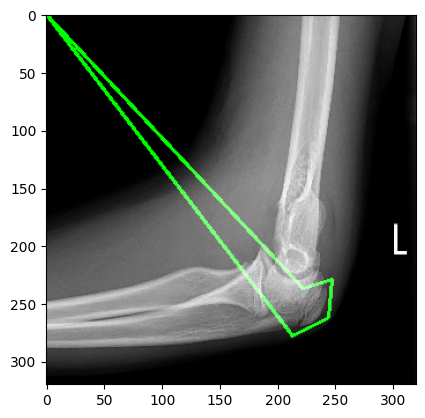

In [264]:
blank_image = np.zeros_like(image)



xA,yA,xB,yB=coordiantes(x0,y0,x1,y1)
# Draw the rectangle on the blank image
#image_with_rectangle = cv2.rectangle(blank_image, (xA, yA), (xB, yB), (255, 0, 0), 2)
image_with_rectangle=cv2.polylines(blank_image, [vertices_np], isClosed=True, color=(0, 255, 0), thickness=2)

# Combine the original image with the image containing the rectangle
result_image = cv2.addWeighted(image, 1, image_with_rectangle, 1, 0)

# Display the result
plt.imshow(result_image)
plt.show()

In [273]:
for i in range(5):
    print(f"x{i}={globals()[f'x{i}']}", end=" \n")
    print(f"y{i}={globals()[f'y{i}']}", end=" \n\n")

print(xA,yA,xB,yB)
vertices_np=np.array([[x0,y0],[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
print("A",vertices_np.shape)
vertices_np = vertices_np.reshape(-1,1,2) 
print("B",vertices_np.shape)

vertices_np

x0=144 
y0=173 

x1=177 
y1=167 

x2=178 
y2=186 

x3=143 
y3=189 

x4=1920 
y4=142 

98 122 345 351
A (5, 2)
B (5, 1, 2)


array([[[ 144,  173]],

       [[ 177,  167]],

       [[ 178,  186]],

       [[ 143,  189]],

       [[1920,  142]]])

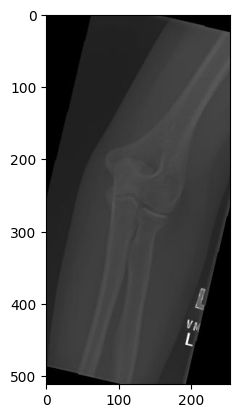

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
plt.show(plt.imshow(A, cmap = 'gray')) #Contrast Limited Adaptive Histogram Equalization (Clahe)


In [ ]:
    def get_labels(self, index):
        if index in self.labels:
            return self.labels[index]
        labels = []
        boxes = []
        text_file = self.files[index % len(self.files)].replace(".jpg", ".txt").replace("images", "labels")
        with open(text_file, mode="r") as f:
            lines = f.readlines()
            for line in lines:
                values = [float(value) for value in line.split()]
                label = int(values[0])
                coords = values[1:]
                coords = torch.reshape(torch.FloatTensor(coords), (int(len(coords)/2), 2))
                size = torch.tensor([self.get_image(index).shape[2], self.get_image(index).shape[1]])
                min_coords = torch.min(coords, dim=0).values * size
                max_coords = torch.max(coords, dim=0).values * size
                box = torch.cat((min_coords, max_coords), dim=0).tolist()
                labels.append(label)
                boxes.append(box)
        self.labels[index] = labels
        self.boxes[index] = torch.ByteTensor(boxes)
        return labels